## CPAB Study
Check the returns of CPAB stocks that had the highest levels of audit risk

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import histprices as hp
%matplotlib inline

## Data Munging
- In the Excel workbook, cleaned the tickers.
- Get tickers from the Excel worksheets.
- Assign a 1 to the year they make it on the audit concerns list.

In [2]:
with pd.ExcelFile('Copy of CPAB Performance Summary.xlsx') as xls:
    df = pd.read_excel(xls, '2015 CPAB Summary', header=None, usecols='M')
    df_2016 = pd.read_excel(xls, '2016 CPAB Summary', header=None, usecols='M')
    df_2017 = pd.read_excel(xls, '2017 CPAB Summary', header=None, usecols='J')
    df_2018 = pd.read_excel(xls, '2018 CPAB Summary', header=None, usecols='K')
df.columns=['tic']
df.dropna(inplace=True)
df = df.drop(df.index[0])
df['2015 Audit'] = 1

df_2016.columns=['tic']
df_2016.dropna(inplace=True)
df_2016 = df_2016.drop(df_2016.index[0])
df_2016['2016 Audit'] = 1

df_2017.columns=['tic']
df_2017.dropna(inplace=True)
df_2017 = df_2017.drop(df_2017.index[0])
df_2017['2017 Audit'] = 1

df_2018.columns=['tic']
df_2018.dropna(inplace=True)
df_2018 = df_2018.drop(df_2018.index[0])
df_2018['2018 Audit'] = 1

df = df.merge(df_2016, how='outer')
df = df.merge(df_2017, how='outer')
df = df.merge(df_2018, how='outer')
df.fillna(0, inplace=True)
df['Years in Audit'] = df.sum(axis=1)

#### Number of companies

In [3]:
print('Number of companies: {}'.format(len(df)))

Number of companies: 342


There were 342 differnet companies over the four years.

#### Study expanded over the years

In [4]:
print(df.sum(axis=0)[:-1])

tic           GM US EquityPPL CN EquityCSU CN EquityBB CN Eq...
2015 Audit                                                   84
2016 Audit                                                   87
2017 Audit                                                  156
2018 Audit                                                  159
dtype: object


CPAB expanded the list under study over the years and the number of companies that were audit concerns grew.

#### Companies grouped by the frequency in the audit concerns group

In [5]:
df.groupby('Years in Audit')['Years in Audit'].sum()

Years in Audit
1.0    232.0
2.0    166.0
3.0     60.0
4.0     28.0
Name: Years in Audit, dtype: float64

Of the 342 different companies 232 appeared only once while 28 appeared 4 times. The appearances are exclusive so a company that appeared 4 times is NOT counted if it made the audit concerns group less than 4.

#### Get ticker list.

In [6]:
tic_list = df['tic'].tolist()

#### Build the pricing table and then save.

In [7]:
def get_price_history(ticker):
    try:
        stock_df = hp.get_bbg_prices(ticker, 20150309, 20180928)
    except (IndexError, RequestError):
        print('Unable to get price history for {}'.format(ticker))
    return stock_df


def get_prices(tic_list):
    # seed the dataframe with SPY and XIC
    price_df = get_price_history('SPY US Equity')
    price_df = price_df.merge(get_price_history('XIC CN Equity'), how='outer', left_index=True, right_index=True)
    i = 0
    for ticker in tic_list[242:]:
        i += 1
        if i % 8 == 0:
            print(ticker)
        else:
            print(ticker, end=' ')
    price_df = price_df.merge(get_price_history(ticker), how='outer', left_index=True, right_index=True)
    return price_df
        
        
def get_perf_history(ticker):
    try:
        stock_df = hp.get_bbg_prices(ticker, 20150309, 20180928)
        stock_df['return'] = np.log(stock_df.iloc[:, 0]) - np.log(stock_df.iloc[:, 0].shift(1))
        perf = {'ticker' : ticker,
                '2015' : np.exp(stock_df['2015-03-10':'2015-12-31']['return'].sum())-1,
                '2016' : np.exp(stock_df['2016-01-01':'2016-12-31']['return'].sum())-1,
                '2017' : np.exp(stock_df['2017-01-01':'2017-12-31']['return'].sum())-1,
                '2018' : np.exp(stock_df['2018-01-01':'2018-09-28']['return'].sum())-1}
    except IndexError:
        perf = {'ticker' : ticker,
                '2015' : float('nan'),
                '2016' : float('nan'),
                '2017' : float('nan'),
                '2018' : float('nan')}
    return perf


def get_post_audit_perf(ret_df, ticker_list, beg_date, end_date):
    values = []
    keys = []
    for ticker in ticker_list:
        try:
            values.append(np.exp(ret_df[beg_date:end_date][ticker].sum())-1)
            keys.append(ticker)
        except (KeyError, ValueError):
            # print('No data for ', ticker)
            pass
    return dict(zip(keys, values)), values

In [8]:
try:
    price_df = pd.read_csv('price_history_first.csv', index_col=0)
except FileNotFoundError:
    print('No price history file. Download data from Bloomberg')
    price_df = get_prices(tick_list)
    price_df.to_csv('price_history_first.csv')
price_df.head()

,SPY US Equity,XIC CN Equity,GM US Equity,PPL CN Equity,CSU CN Equity,BB CN Equity,MX CN Equity,PJC/A CN Equity,HBC CN Equity,TSGI CN Equity,...,NIF-U CN Equity,ATY CN Equity,GDL CN Equity,MCR CN Equity,AT CN Equity,IFX CN Equity,MBA CN Equity,PPR CN Equity,SEN CN Equity,HEO CN Equity
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-09,208.3600,23.62,37.66,39.84,434.50,12.44,71.37,26.83,26.85,32.42,...,3.01,0.51,10.10,1.90,0.90,0.44,0.295,NaN,NaN,1.40
2015-03-10,204.9800,23.28,37.55,39.46,425.21,12.39,68.08,26.33,26.50,31.84,...,2.87,0.52,9.90,1.94,NaN,NaN,0.295,NaN,NaN,1.40
2015-03-11,204.5000,23.40,37.78,40.02,441.22,12.64,68.45,26.47,26.25,29.16,...,2.72,0.51,10.01,1.95,0.95,NaN,0.270,NaN,1.06,1.34
2015-03-12,207.1000,23.49,38.43,40.22,439.53,12.62,68.42,26.64,26.07,31.92,...,2.85,0.50,10.05,1.98,1.00,NaN,0.270,NaN,1.03,1.34
2015-03-13,205.8272,23.44,38.05,40.00,429.80,12.52,66.35,26.04,26.03,30.49,...,2.97,0.52,10.04,1.94,1.00,NaN,0.270,NaN,1.01,1.37


#### Calculate daily log returns

In [9]:
ret_df = np.log(price_df) - np.log(price_df.shift(1))
ret_df['2018-06-30':].head(10)

,SPY US Equity,XIC CN Equity,GM US Equity,PPL CN Equity,CSU CN Equity,BB CN Equity,MX CN Equity,PJC/A CN Equity,HBC CN Equity,TSGI CN Equity,...,NIF-U CN Equity,ATY CN Equity,GDL CN Equity,MCR CN Equity,AT CN Equity,IFX CN Equity,MBA CN Equity,PPR CN Equity,SEN CN Equity,HEO CN Equity
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,0.002136,NaN,0.002535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,-0.003537,NaN,-0.013509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-04,NaN,0.002707,NaN,0.000000,-0.010402,0.018377,0.007631,NaN,0.006001,-0.003870,...,0.007605,-0.020203,NaN,0.014135,-0.017242,-0.054067,NaN,0.026317,NaN,-0.015267
2018-07-05,NaN,-0.002320,NaN,0.000441,0.010920,-0.022249,-0.002788,NaN,0.025318,-0.033620,...,0.000000,0.078472,NaN,0.024265,-0.017544,-0.022473,NaN,0.012903,NaN,0.015267
2018-07-06,0.008423,0.006175,-0.007885,0.022003,0.014069,0.008498,0.012165,NaN,-0.015960,-0.005927,...,0.000000,-0.038466,0.033902,-0.006873,0.017544,-0.011429,0.013423,-0.012903,NaN,-0.030772
2018-07-09,0.008964,0.005372,0.014954,-0.001078,0.018184,0.013751,0.008555,NaN,-0.004243,0.015380,...,-0.007605,0.000000,0.009290,0.000000,-0.044452,NaN,0.013245,0.012903,NaN,0.000000
2018-07-10,0.003592,0.005724,0.008517,0.005807,0.020620,0.003786,-0.000947,NaN,0.003396,-0.005871,...,0.000000,0.000000,-0.043192,0.020479,0.061694,NaN,-0.013245,0.050010,NaN,0.030772
2018-07-11,-0.007341,-0.007256,-0.019902,-0.006670,-0.015865,-0.014465,-0.025264,NaN,0.001693,-0.015685,...,-0.015385,0.038466,NaN,-0.010187,-0.043675,-0.011561,0.013245,-0.037271,NaN,0.007547
2018-07-12,0.009025,0.008397,-0.000764,0.011804,0.045249,0.018990,0.012658,NaN,0.004221,-0.029484,...,0.015385,-0.058269,NaN,0.006803,-0.018019,NaN,-0.013245,-0.012739,NaN,-0.054067


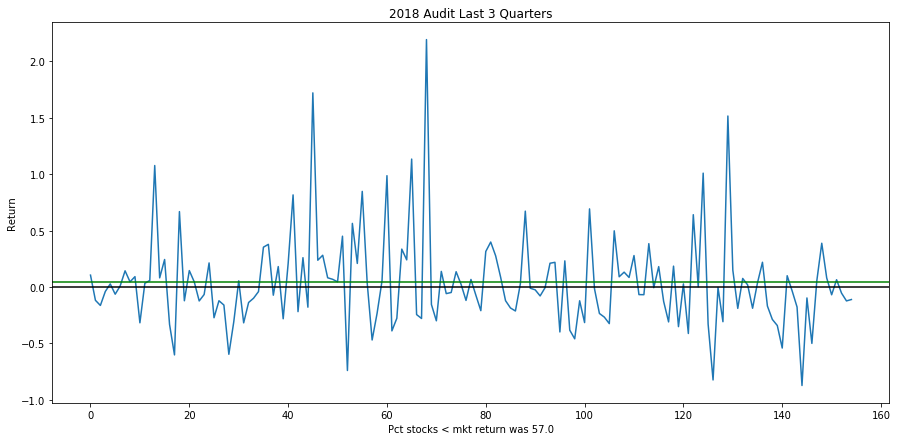

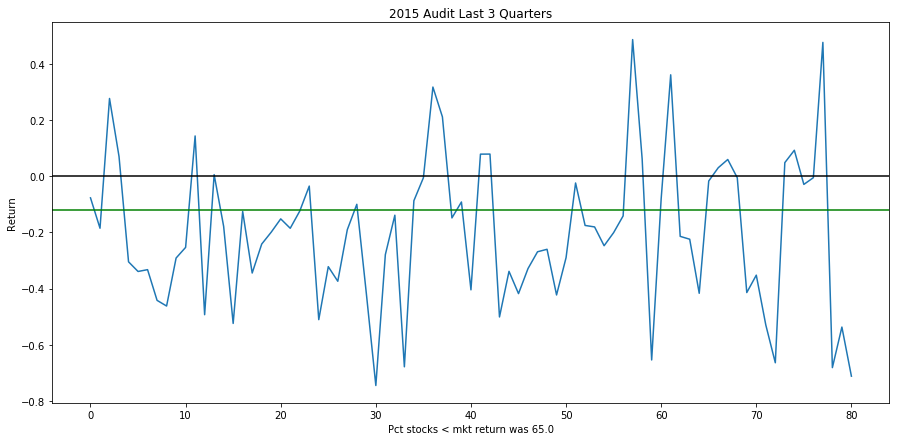

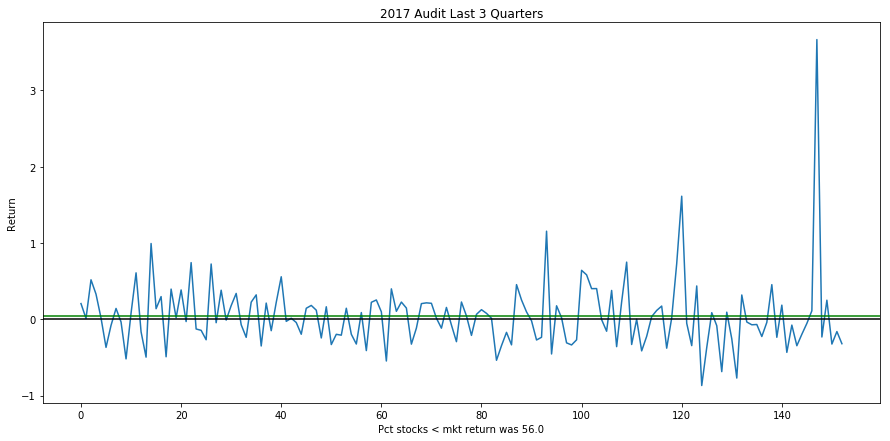

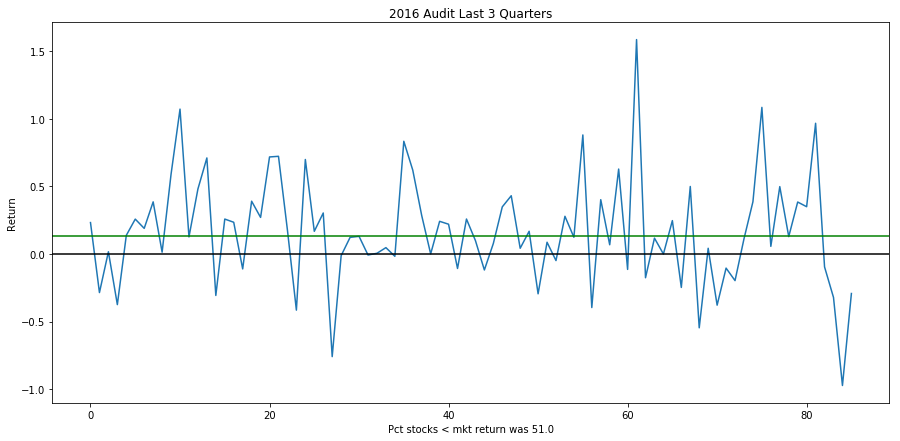

In [10]:
audit_study_dict = {'2015 Audit': ['2015-03-10', '2015-12-31'],
                    '2016 Audit': ['2016-03-10', '2016-12-31'],
                    '2017 Audit': ['2017-03-10', '2017-12-31'],
                    '2018 Audit': ['2018-03-10', '2018-09-28']}
for yr in audit_study_dict:
#    print(yr, audit_study_dict[yr][0], audit_study_dict[yr][1])
    tics_in_audit = df[df[yr] > 0]['tic'].tolist()
    try:
        tics_in_audit.remove('SPTSX Index')
    except ValueError:
        pass
    try:
        tics_in_audit.remove('SPX Index')
    except ValueError:
        pass
    audit_yr_dict, audit_yr_ret = get_post_audit_perf(ret_df, tics_in_audit,
                                                      audit_study_dict[yr][0],
                                                      audit_study_dict[yr][1])
    mkt_ret =np.exp(ret_df[audit_study_dict[yr][0]:audit_study_dict[yr][1]]['SPTSX Index'].sum())-1 
    plt.figure(figsize=(15, 7))
    plt.plot(audit_yr_ret)
    plt.title(yr + ' Last 3 Quarters')
    plt.ylabel('Return')
    plt.xlabel('Pct stocks < mkt return was ' 
               + str(np.round(np.size(np.where(audit_yr_ret < mkt_ret))/np.size(audit_yr_ret) * 100)))
    plt.axhline(0.0, color='black')
    plt.axhline(mkt_ret, color='g')
    plt.savefig(yr + ' Last 3 Quarters');

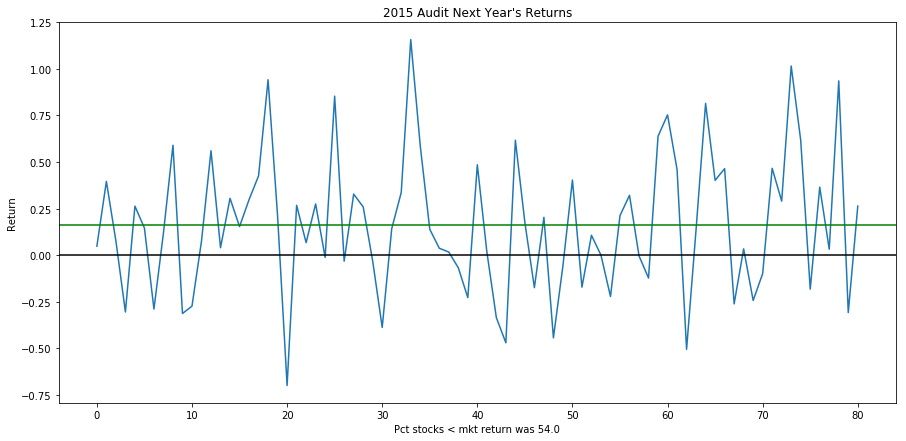

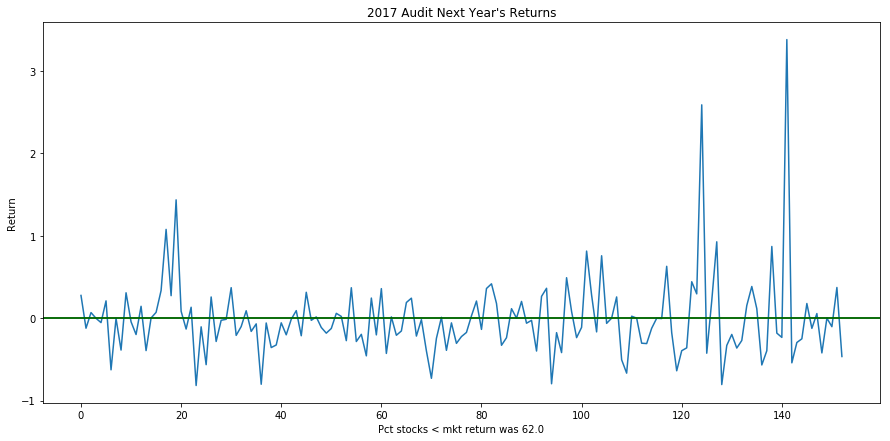

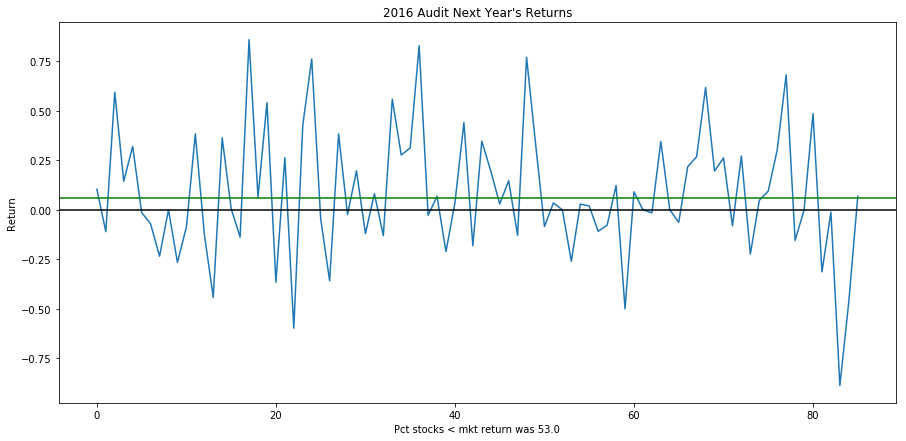

In [11]:
audit_study_dict = {'2015 Audit': ['2016-01-01', '2016-12-31'],
                    '2016 Audit': ['2017-01-01', '2017-12-31'],
                    '2017 Audit': ['2018-01-01', '2018-09-28']}
for yr in audit_study_dict:
#    print(yr, audit_study_dict[yr][0], audit_study_dict[yr][1])
    tics_in_audit = df[df[yr] > 0]['tic'].tolist()
    try:
        tics_in_audit.remove('SPTSX Index')
    except ValueError:
        pass
    try:
        tics_in_audit.remove('SPX Index')
    except ValueError:
        pass
    audit_yr_dict, audit_yr_ret = get_post_audit_perf(ret_df, tics_in_audit,
                                                      audit_study_dict[yr][0],
                                                      audit_study_dict[yr][1])
    mkt_ret =np.exp(ret_df[audit_study_dict[yr][0]:audit_study_dict[yr][1]]['SPTSX Index'].sum())-1 
    plt.figure(figsize=(15, 7))
    plt.plot(audit_yr_ret)
    plt.title(yr + ' Next Year\'s Returns')
    plt.ylabel('Return')
    plt.xlabel('Pct stocks < mkt return was ' 
               + str(np.round(np.size(np.where(audit_yr_ret < mkt_ret))/np.size(audit_yr_ret) * 100)))
    plt.axhline(0.0, color='black')
    plt.axhline(mkt_ret, color='g')
    plt.savefig(yr + ' Next Years Returns');

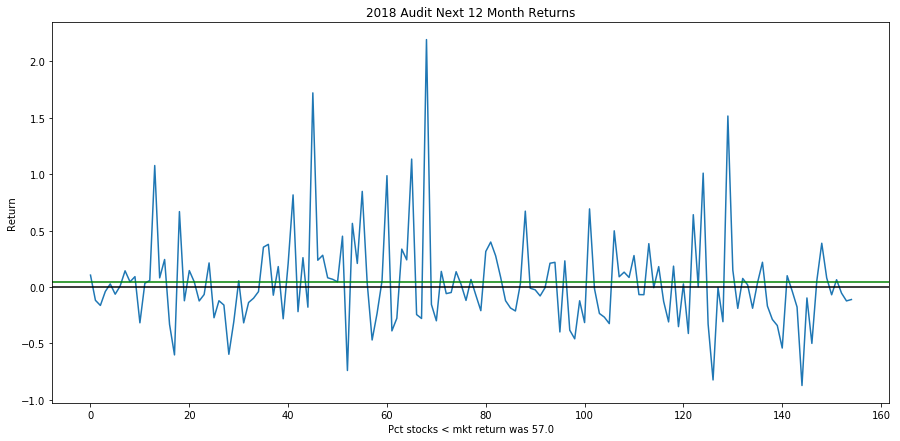

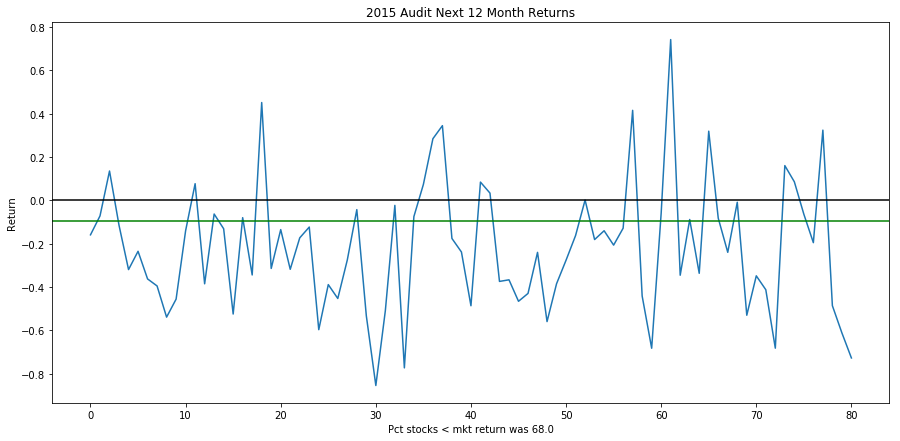

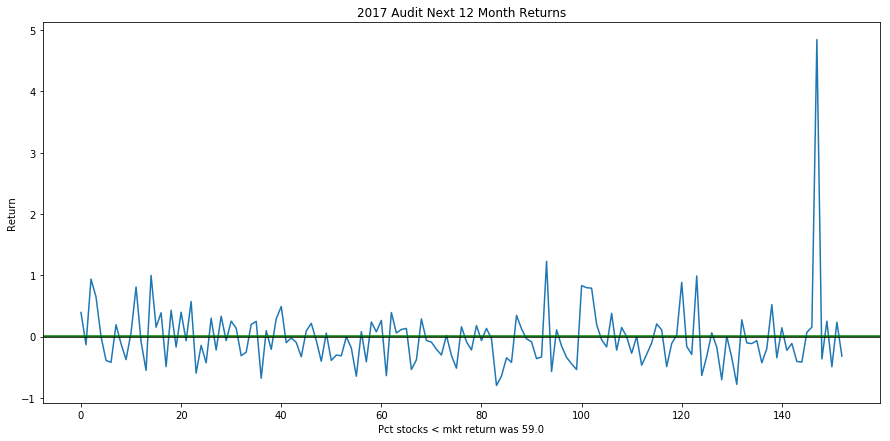

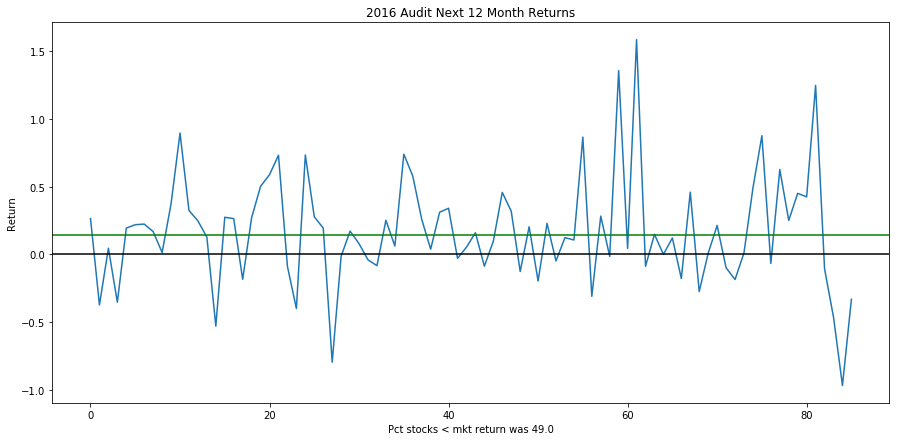

In [12]:
audit_study_dict = {'2015 Audit': ['2015-03-10', '2016-03-10'],
                    '2016 Audit': ['2016-03-10', '2017-03-10'],
                    '2017 Audit': ['2017-03-10', '2018-03-10'],
                    '2018 Audit': ['2018-03-10', '2018-09-28']}
for yr in audit_study_dict:
    # print(yr, audit_study_dict[yr][0], audit_study_dict[yr][1])
    tics_in_audit = df[df[yr] > 0]['tic'].tolist()
    try:
        tics_in_audit.remove('SPTSX Index')
    except ValueError:
        pass
    try:
        tics_in_audit.remove('SPX Index')
    except ValueError:
        pass
    audit_yr_dict, audit_yr_ret = get_post_audit_perf(ret_df, tics_in_audit,
                                                      audit_study_dict[yr][0],
                                                      audit_study_dict[yr][1])
    mkt_ret =np.exp(ret_df[audit_study_dict[yr][0]:audit_study_dict[yr][1]]['SPTSX Index'].sum())-1 
    plt.figure(figsize=(15, 7))
    plt.plot(audit_yr_ret)
    plt.title(yr + ' Next 12 Month Returns')
    plt.ylabel('Return')
    plt.xlabel('Pct stocks < mkt return was ' 
               + str(np.round(np.size(np.where(audit_yr_ret < mkt_ret))/np.size(audit_yr_ret) * 100)))
    plt.axhline(0.0, color='black')
    plt.axhline(mkt_ret, color='g')
    plt.savefig(yr + ' Next 12 Month Returns');

In [16]:
audit_study_dict1 = {'2015 Audit': ['2015-03-10', '2016-03-10'],
                     '2016 Audit': ['2016-03-10', '2017-03-10'],
                     '2017 Audit': ['2017-03-10', '2018-03-10'],
                     '2018 Audit': ['2018-03-10', '2018-09-28'],}

audit_study_dict2 = {'2015 Audit': ['2016-01-01', '2016-12-31'],
                     '2016 Audit': ['2017-01-01', '2017-12-31'],
                     '2017 Audit': ['2018-01-01', '2018-09-28'],}

audit_study_dict3 = {'2015 Audit': ['2015-03-10', '2015-12-31'],
                     '2016 Audit': ['2016-03-10', '2016-12-31'],
                     '2017 Audit': ['2017-03-10', '2017-12-31'],
                     '2018 Audit': ['2018-03-10', '2018-09-28']}

list_of_dict = [audit_study_dict1, audit_study_dict2, audit_study_dict3]
agg_list = []
for audit_study_dict in list_of_dict:
    for yr in audit_study_dict:
        print(yr, audit_study_dict[yr][0], audit_study_dict[yr][1])
        tics_in_audit = df[df[yr] > 0]['tic'].tolist()
        try:
            tics_in_audit.remove('SPTSX Index')
        except ValueError:
            pass
        try:
            tics_in_audit.remove('SPX Index')
        except ValueError:
            pass
        audit_yr_dict, audit_yr_ret = get_post_audit_perf(ret_df, tics_in_audit,
                                                          audit_study_dict[yr][0],
                                                          audit_study_dict[yr][1])
        mkt_ret = np.exp(ret_df[audit_study_dict[yr][0]:audit_study_dict[yr][1]]['SPTSX Index'].sum())-1 
        num_below_mkt = np.size(np.where(audit_yr_ret < mkt_ret))
        num_above_mkt = np.size(np.where(audit_yr_ret >= mkt_ret))
        pct_below_mkt = num_below_mkt/np.size(audit_yr_ret)
        audit_yr_ret_np = np.array(audit_yr_ret)
        avg_ret_below = audit_yr_ret_np[audit_yr_ret_np < mkt_ret].mean()
        avg_ret_above = audit_yr_ret_np[audit_yr_ret_np >= mkt_ret].mean()
        med_ret_below = np.median(audit_yr_ret_np[audit_yr_ret_np < mkt_ret])
        med_ret_above = np.median(audit_yr_ret_np[audit_yr_ret_np >= mkt_ret])
        agg_list.append([yr, str(audit_study_dict[yr][0]) + ' to ' + str(audit_study_dict[yr][1]), 
                         num_below_mkt, pct_below_mkt, num_above_mkt, 1 - pct_below_mkt,
                         avg_ret_below, med_ret_below, avg_ret_above, med_ret_above, mkt_ret])
agg_df = pd.DataFrame(agg_list)
agg_df.columns = ['Audit', 'Return Period', 'Num Below', 'Pct Below', 'Num Above', 'Pct Above',
                  'Avg Ret Below', 'Med Ret Below', 'Avg Ret Above', 'Med Ret Above', 'Mkt Ret']

2018 Audit 2018-03-10 2018-09-28
2015 Audit 2015-03-10 2016-03-10
2017 Audit 2017-03-10 2018-03-10
2016 Audit 2016-03-10 2017-03-10
2015 Audit 2016-01-01 2016-12-31
2017 Audit 2018-01-01 2018-09-28
2016 Audit 2017-01-01 2017-12-31
2018 Audit 2018-03-10 2018-09-28
2015 Audit 2015-03-10 2015-12-31
2017 Audit 2017-03-10 2017-12-31
2016 Audit 2016-03-10 2016-12-31


In [17]:
agg_df.sort_values(['Audit', 'Return Period'])

,Audit,Return Period,Num Below,Pct Below,Num Above,Pct Above,Avg Ret Below,Med Ret Below,Avg Ret Above,Med Ret Above,Mkt Ret
8,2015 Audit,2015-03-10 to 2015-12-31,53,0.654321,28,0.345679,-0.350204,-0.328711,0.080124,0.039414,-0.119597
1,2015 Audit,2015-03-10 to 2016-03-10,55,0.679012,26,0.320988,-0.370631,-0.362141,0.110963,0.053967,-0.094613
4,2015 Audit,2016-01-01 to 2016-12-31,44,0.543210,37,0.456790,-0.110262,-0.044704,0.485263,0.403277,0.163568
10,2016 Audit,2016-03-10 to 2016-12-31,44,0.511628,42,0.488372,-0.122992,-0.032834,0.470196,0.385418,0.130297
3,2016 Audit,2016-03-10 to 2017-03-10,42,0.488372,44,0.511628,-0.131317,-0.075305,0.456077,0.315162,0.146496
6,2016 Audit,2017-01-01 to 2017-12-31,46,0.534884,40,0.465116,-0.145895,-0.085801,0.345177,0.307510,0.057428
9,2017 Audit,2017-03-10 to 2017-12-31,85,0.555556,68,0.444444,-0.220243,-0.208612,0.372805,0.224981,0.043150
2,2017 Audit,2017-03-10 to 2018-03-10,91,0.594771,62,0.405229,-0.294140,-0.301559,0.395266,0.235230,0.002520
5,2017 Audit,2018-01-01 to 2018-09-28,95,0.620915,58,0.379085,-0.256402,-0.208957,0.387911,0.250421,0.001747
0,2018 Audit,2018-03-10 to 2018-09-28,89,0.574194,66,0.425806,-0.200607,-0.160336,0.366507,0.215918,0.042345
